In [ ]:
!pip install hazm
#!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 316 kB 6.5 MB/s 
     |████████████████████████████████| 1.4 MB 35.6 MB/s 
     |████████████████████████████████| 233 kB 38.4 MB/s 
  Created wheel for nltk: filename=nltk-3.3-py3-none-any.whl size=1394486 sha256=61051d2b265e70dcad549e2679d32c455499318a9d68c50ad3fa18ec2a2b764c
  Stored in directory: /root/.cache/pip/wheels/9b/fd/0c/d92302c876e5de87ebd7fc0979d82edb93e2d8d768bf71fac4
  Created wheel for libwapiti: filename=libwapiti-0.2.1-cp37-cp37m-linux_x86_64.whl size=154003 sha256=5d713aca9c6d578d5be81815fa39ff30c18a5f4a2e06b46fa0a4ecdc082dbbc9
  Stored in directory: /root/.cache/pip/wheels/ab/b2/5b/0fe4b8f5c0e65341e8ea7bb3f4a6ebabfe8b1ac31322392dbf
Successfully built nltk libwapiti
  Attempting uninstall: nltk
    Found existing installation: nltk 3.7
    Uninstalling nltk-3.7:
      Successfully uninstalled nltk-3.7


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D,Bidirectional
from keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
#from __future__ import unicode_literals
#from hazm import *
import gc

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Input datasets
I read from 5 datasets and combine them toghether

because of the datasets fault, I can't separate them in file reading time, so I read it as a 1 column

In [ ]:
csv1 = pd.read_csv("/content/drive/MyDrive/NerDatas/Persian-NER-part1.txt", header=None, delimiter="~", names = ['All'], encoding_errors = 'ignore', low_memory=False)
csv2 = pd.read_csv("/content/drive/MyDrive/NerDatas/Persian-NER-part2.txt", header=None, delimiter="~", names = ['All'], encoding_errors = 'ignore', low_memory=False)
csv3 = pd.read_csv("/content/drive/MyDrive/NerDatas/Persian-NER-part3.txt", header=None, delimiter="~", names = ['All'], encoding_errors = 'ignore', low_memory=False)
csv4 = pd.read_csv("/content/drive/MyDrive/NerDatas/Persian-NER-part4.txt", header=None, delimiter="~", names = ['All'], encoding_errors = 'ignore', low_memory=False)
#csv5 = pd.read_csv("/content/drive/MyDrive/NerDatas/Persian-NER-part5.txt", header=None, delimiter="~", names = ['All'], encoding_errors = 'ignore', low_memory=False)     #changable

In [ ]:
mainCsv = pd.DataFrame(columns=['All'])
mainCsv = mainCsv.append(csv1, ignore_index=True)
mainCsv = mainCsv.append(csv2, ignore_index=True)
mainCsv = mainCsv.append(csv3, ignore_index=True)
mainCsv = mainCsv.append(csv4, ignore_index=True)
#data = data.append(csv5, ignore_index=True)   #changeable
mainCsv

,All
0,ویکی‌پدیای\tO
1,انگلیسی\tO
2,در\tB-DAT
3,تاریخ\tI-DAT
4,۱۵\tI-DAT
...,...
10527407,روی\tO
10527408,میز\tO
10527409,گزارشگران\tO
10527410,کوبیدند\tO


In [ ]:
tmp = mainCsv['All'].str.rsplit("\t", 1)
dataWord = pd.DataFrame(list(tmp), columns = ['Token', 'NameEntity'])
dataWord

,Token,NameEntity
0,ویکی‌پدیای,O
1,انگلیسی,O
2,در,B-DAT
3,تاریخ,I-DAT
4,۱۵,I-DAT
...,...,...
10527407,روی,O
10527408,میز,O
10527409,گزارشگران,O
10527410,کوبیدند,O


(-1.1033137785109566,
 1.102811138826456,
 -1.1050851919181333,
 1.1002421713451351)

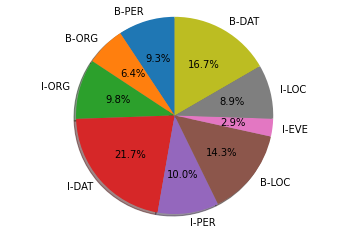

In [ ]:
x = dataWord['NameEntity'].value_counts()[1:-1]
x = shuffle(x)
fig1, ax1 = plt.subplots()
ax1.pie(x.values, labels=x.keys(), autopct='%1.1f%%',shadow=True, startangle=90)
ax1.axis('equal') 

In [ ]:
dataWord['NameEntity'].value_counts()

O        8728635
I-DAT     383590
B-DAT     294479
B-LOC     252790
I-PER     178051
I-ORG     174526
B-PER     164234
I-LOC     158827
B-ORG     113397
I-EVE      51561
B-EVE      27310
Name: NameEntity, dtype: int64

In [ ]:
nanIndices = dataWord['NameEntity'][dataWord['NameEntity'].isnull().values].index
nanIndices

Int64Index([ 1193638,  2569124,  2613297,  5508457,  7587616,  8104097,
             8265958,  8566774,  8709133,  8753008,  8968246, 10258056],
           dtype='int64')

In [ ]:
dataWord.iloc[nanIndices]

,Token,NameEntity
1193638,http://turnbull.mcs.st-and.ac.uk/,None
2569124,http://kiau.ac.ir/,None
2613297,2,None
5508457,http://sharif.edu/,None
7587616,members.tripod.com/,None
8104097,http://www.rph.wa.gov.au/,None
8265958,http://sharif.edu/,None
8566774,http://web.eecs.umich.edu/,None
8709133,http://lisa.cs.duke.edu/,None
8753008,http://freepages.genealogy.rootsweb.ancestry.com/,None


In [ ]:
dataWord = dataWord.dropna()
dataWord = dataWord.reset_index(drop = True)

In [ ]:
def makeSentences(dotIndices, data):
  columns = ['Text', 'Label']
  df= []
  begin = 0
  for i in range(len(dotIndices)):
    tmp = data.iloc[begin:dotIndices[i]]
    begin = dotIndices[i] + 1
    _list=[]
    _list.append(' '.join(list(tmp['Token'])))
    _list.append(' '.join(list(tmp['NameEntity'])))
    df.append(_list)
  df= pd.DataFrame(df,columns=list(columns))
  return df

In [ ]:
def bad_token_indices(tokens): #inja / ro ham gozashti khaaaaak 
  bads = []
  badChars = ['(', ')', ' ', '[', ']', '{', '}', ';', ':', '،', '-', '>', '<', '?', '!', '=', '\'', '\"', '@', '#']
  for i in range(len(tokens)):
    for badChar in badChars:
      if(badChar in tokens.iloc[i] and '.' not in tokens.iloc[i]):
        bads.append(i)
        break
  return bads

In [ ]:
badTokenIndices = bad_token_indices(dataWord['Token'])

In [ ]:
np.save('/content/drive/MyDrive/NerDatas/innerInputs/badTokenIndices.np', np.array(badTokenIndices))

In [ ]:
badTokenIndices = np.load('/content/drive/MyDrive/NerDatas/innerInputs/badTokenIndices.np.npy')

In [ ]:
dataWord.drop(labels = badTokenIndices, axis = 0, inplace=True)

In [ ]:
dataWord = dataWord.reset_index(drop = True)

In [ ]:
def calc_average_list  

In [4]:
def label_to_one_hot(value):
  list_classes = ['O', 'B-DAT', 'I-DAT', 'B-LOC', 'I-LOC', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-EVE', 'I-EVE']
  if value == list_classes[0]:
    return [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
  if value == list_classes[1]:
    return [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
  if value == list_classes[2]:
    return [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
  if value == list_classes[3]:
    return [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
  if value == list_classes[4]:
    return [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
  if value == list_classes[5]:
    return [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
  if value == list_classes[6]:
    return [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
  if value == list_classes[7]:
    return [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
  if value == list_classes[8]:
    return [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
  if value == list_classes[9]:
    return [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
  if value == list_classes[10]:
    return [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]

In [ ]:
def removeBadSentences(X, Y):
  newX = []
  newY = []
  indices = []
  ind = -1

  for x, y in zip(X, Y):
    ind += 1
    if len(x) == len(y):
      indices.append(ind)
      newX.append(x)
      newY.append(y)

  return newX, newY, indices

In [14]:
def badPercentage(x, y):
  ind = -1
  notEquallen = 0

  for a,b in zip(x, y):
    ind += 1
    if len(a) != len(b):
      notEquallen += 1

  return notEquallen / len(list_tokenized_train)

In [ ]:
dotIndices = list(dataWord['Token'][dataWord['Token'] == '.'].index)
dataSentences = makeSentences(dotIndices, dataWord)

In [ ]:
dataSentences

,Text,Label
0,ویکی‌پدیای انگلیسی در تاریخ ۱۵ ژانویه ۲۰۰۱ میل...,O O B-DAT I-DAT I-DAT I-DAT I-DAT B-DAT B-DAT ...
1,بنیان‌گذاران آن جیمی ولز و لری سنگر هستند,O O B-PER I-PER O B-PER I-PER O
2,هم‌اکنون بنیاد غیرانتفاعی بنیاد ویکی‌مدیا پروژ...,O O O B-ORG I-ORG O O O O O
3,کارساز وب اصلی این وبگاه در شهر تامپا ی فلورید...,O O O O O O O B-LOC O B-LOC O
4,همچنین میزبان‌های اضافی دیگری هم در شهرهای آمس...,O O O O O O O B-LOC O B-LOC O O O O O
...,...,...
400326,۲۰۱۳ درگذشت و آندرتیکر و کین برای او مراسم یاد...,O O O B-ORG I-ORG I-ORG O O O O O
400327,در تاریخ ۲۳ ژوئیه ۲۰۱۲ در‌حین اجرای شوی WWE را...,B-DAT I-DAT B-DAT I-DAT I-DAT O O O O O O O O ...
400328,در سال بعد ۲۰۱۳ کمی قبل از رستلمنیا ۲۹ پول بیر...,B-DAT B-DAT I-DAT O O O O B-EVE I-EVE O O O O ...
400329,در رستلمنیا ۲۹ یک مسابقه بین آندرتیکر و CM پان...,O B-EVE I-EVE O O O O O O O O O O O O O O O O ...


## Split data into X and y

In [ ]:
yLabel = dataSentences['Label']
sentences = dataSentences['Text']

## Tokenization

In [ ]:
max_features = 750025   # changeable
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(sentences))
list_tokenized_train = tokenizer.texts_to_sequences(sentences)

y = [[label_to_one_hot(c) for c in ey.split(' ')] for ey in yLabel]

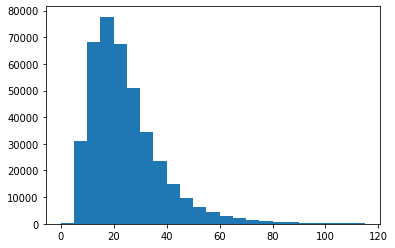

In [ ]:
senLens = [len(sen) for sen in list_tokenized_train]
plt.hist(senLens, bins = np.arange(0,120,5))
plt.show()

## Find bad Sentences and remove them 

In [ ]:
badPercentage(list_tokenized_train, y)

0.0

In [ ]:
list_tokenized_train, y, goodIndices = removeBadSentences(list_tokenized_train, y)

In [15]:
badPercentage(list_tokenized_train, y)

0.0

In [ ]:
dataWord = dataWord.iloc[goodIndices]              #run once...
dataSentenses = dataSentenses.iloc[goodIndices]

In [ ]:
dataSentenses = dataSentenses.reset_index(drop = True)

In [ ]:
sentences = sentences.iloc[goodIndices]            #run once...


In [ ]:
dataSentences = dataSentences.iloc[goodIndices]     #run once...

In [ ]:
dataSentences = dataSentences.reset_index(drop = True)  #run once...

In [ ]:
dataSentences

In [ ]:
len(sentences)

390935

In [ ]:
senLens = [len(sen) for sen in list_tokenized_train]
len(senLens)

390935

400331

In [ ]:
senInfo = pd.DataFrame()
senInfo['Lens'] = senLens
senInfo['O_Count'] = list(dataSentences['Label'].str.count('O'))
senInfo

,Lens,O_Count
0,20,11
1,8,4
2,10,10
3,11,11
4,15,15
...,...,...
390930,11,11
390931,45,40
390932,30,25
390933,28,25


In [ ]:
senInfo['NE_Count'] = senInfo['Lens'] - senInfo['O_Count']
senInfo

,Lens,O_Count,NE_Count
0,20,11,9
1,8,4,4
2,10,10,0
3,11,11,0
4,15,15,0
...,...,...,...
390930,11,11,0
390931,45,40,5
390932,30,25,5
390933,28,25,3


In [ ]:
senInfo.describe()

,Lens,O_Count,NE_Count,NE/Len
count,390935.000000,390935.000000,390935.000000,390935.000000
mean,24.030673,21.317314,2.713359,12.791833
std,14.578518,14.009967,3.024846,13.908008
min,1.000000,0.000000,0.000000,0.000000
25%,14.000000,12.000000,0.000000,0.000000
50%,21.000000,18.000000,2.000000,9.756098
75%,30.000000,27.000000,4.000000,20.000000
max,788.000000,727.000000,127.000000,100.000000


In [ ]:
senInfo['NE/Len'] = senInfo['NE_Count'] / (senInfo['Lens']) * 100

In [ ]:
def balanced_sen(NE_divide_Len, NE_Count, percent = 8, least_count = 3):
  balancedIndices = []
  ind = -1
  for neC, neD in zip(NE_divide_Len, NE_Count):
    ind += 1
    if neC >= percent or neD > least_count:
      balancedIndices.append(ind)
  return balancedIndices

In [ ]:
balanced_indices = balanced_sen(senInfo['NE/Len'], senInfo['NE_Count'])

In [ ]:
senInfo.iloc[balanced_indices]

,Lens,O_Count,NE_Count,NE/Len
0,20,11,9,45.000000
1,8,4,4,50.000000
5,28,24,4,14.285714
6,29,24,5,17.241379
8,22,13,9,40.909091
...,...,...,...,...
390928,20,12,8,40.000000
390929,35,30,5,14.285714
390931,45,40,5,11.111111
390932,30,25,5,16.666667


In [ ]:
dataSentences

,Text,Label
0,ویکی‌پدیای انگلیسی در تاریخ ۱۵ ژانویه ۲۰۰۱ میل...,O O B-DAT I-DAT I-DAT I-DAT I-DAT B-DAT B-DAT ...
1,بنیان‌گذاران آن جیمی ولز و لری سنگر هستند,O O B-PER I-PER O B-PER I-PER O
2,هم‌اکنون بنیاد غیرانتفاعی بنیاد ویکی‌مدیا پروژ...,O O O B-ORG I-ORG O O O O O
3,کارساز وب اصلی این وبگاه در شهر تامپا ی فلورید...,O O O O O O O B-LOC O B-LOC O
4,همچنین میزبان‌های اضافی دیگری هم در شهرهای آمس...,O O O O O O O B-LOC O B-LOC O O O O O
...,...,...
390930,۲۰۱۳ درگذشت و آندرتیکر و کین برای او مراسم یاد...,O O O B-ORG I-ORG I-ORG O O O O O
390931,در تاریخ ۲۳ ژوئیه ۲۰۱۲ در‌حین اجرای شوی WWE را...,B-DAT I-DAT B-DAT I-DAT I-DAT O O O O O O O O ...
390932,در سال بعد ۲۰۱۳ کمی قبل از رستلمنیا ۲۹ پول بیر...,B-DAT B-DAT I-DAT O O O O B-EVE I-EVE O O O O ...
390933,در رستلمنیا ۲۹ یک مسابقه بین آندرتیکر و CM پان...,O B-EVE I-EVE O O O O O O O O O O O O O O O O ...


In [ ]:
dataSentences = dataSentences.iloc[balanced_indices]
dataSentences = dataSentences.reset_index(drop = True)

In [ ]:
dataSentences

,Text,Label
0,ویکی‌پدیای انگلیسی در تاریخ ۱۵ ژانویه ۲۰۰۱ میل...,O O B-DAT I-DAT I-DAT I-DAT I-DAT B-DAT B-DAT ...
1,بنیان‌گذاران آن جیمی ولز و لری سنگر هستند,O O B-PER I-PER O B-PER I-PER O
2,ویکی‌پدیا از پایان آوریل ۲۰۰۷ تاکنون یکی از ۱۰...,O B-DAT I-DAT I-DAT I-DAT O O O O O O O O O O ...
3,در میان تمام زبان‌های ویکی‌پدیا تا دسامبر ۲۰۱۵...,O O O O O B-DAT I-DAT I-DAT B-DAT I-DAT O O O ...
4,نوپدیا در تاریخ ۹ مارس ۲۰۰۰ میلادی ۱۹ اسفند ۱۳...,O B-DAT I-DAT I-DAT I-DAT I-DAT B-DAT B-DAT I-...
...,...,...
216515,پس‌از‌آن دیگر آندرتیکر حضور نیافت تا سال بعد ک...,O O O O O B-DAT I-DAT I-DAT O O B-EVE I-EVE I-...
216516,حضور نیافت تا‌این‌که در سال ۲۰۱۲ برای حمایت دو...,O O O B-DAT B-DAT I-DAT O O O O O O B-PER I-PE...
216517,در تاریخ ۲۳ ژوئیه ۲۰۱۲ در‌حین اجرای شوی WWE را...,B-DAT I-DAT B-DAT I-DAT I-DAT O O O O O O O O ...
216518,در سال بعد ۲۰۱۳ کمی قبل از رستلمنیا ۲۹ پول بیر...,B-DAT B-DAT I-DAT O O O O B-EVE I-EVE O O O O ...


In [ ]:
senInfo

,Lens,O_Count,NE_Count,NE/Len
0,20,11,9,45.000000
1,8,4,4,50.000000
2,10,10,0,0.000000
3,11,11,0,0.000000
4,15,15,0,0.000000
...,...,...,...,...
390930,11,11,0,0.000000
390931,45,40,5,11.111111
390932,30,25,5,16.666667
390933,28,25,3,10.714286


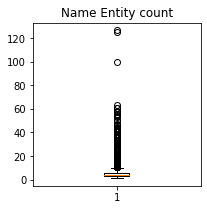

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize =(3, 3))
plt.boxplot(senInfo['NE_Count'])
plt.title('Name Entity count')
plt.show()

In [ ]:
dataSentences.to_csv('/content/drive/MyDrive/NerDatas/innerInputs/dataSentences')

In [5]:
dataSentences = pd.read_csv('/content/drive/MyDrive/NerDatas/innerInputs/dataSentences2')

In [ ]:
dataSentences.to_csv('/content/drive/MyDrive/NerDatas/innerInputs/dataSentences2')

In [6]:
dataSentences = dataSentences[['Text', 'Label']]

In [ ]:
dataSentences

,Text,Label
0,ویکی‌پدیای انگلیسی در تاریخ ۱۵ ژانویه ۲۰۰۱ میل...,O O B-DAT I-DAT I-DAT I-DAT I-DAT B-DAT B-DAT ...
1,بنیان‌گذاران آن جیمی ولز و لری سنگر هستند,O O B-PER I-PER O B-PER I-PER O
2,ویکی‌پدیا از پایان آوریل ۲۰۰۷ تاکنون یکی از ۱۰...,O B-DAT I-DAT I-DAT I-DAT O O O O O O O O O O ...
3,در میان تمام زبان‌های ویکی‌پدیا تا دسامبر ۲۰۱۵...,O O O O O B-DAT I-DAT I-DAT B-DAT I-DAT O O O ...
4,نوپدیا در تاریخ ۹ مارس ۲۰۰۰ میلادی ۱۹ اسفند ۱۳...,O B-DAT I-DAT I-DAT I-DAT I-DAT B-DAT B-DAT I-...
...,...,...
216515,پس‌از‌آن دیگر آندرتیکر حضور نیافت تا سال بعد ک...,O O O O O B-DAT I-DAT I-DAT O O B-EVE I-EVE I-...
216516,حضور نیافت تا‌این‌که در سال ۲۰۱۲ برای حمایت دو...,O O O B-DAT B-DAT I-DAT O O O O O O B-PER I-PE...
216517,در تاریخ ۲۳ ژوئیه ۲۰۱۲ در‌حین اجرای شوی WWE را...,B-DAT I-DAT B-DAT I-DAT I-DAT O O O O O O O O ...
216518,در سال بعد ۲۰۱۳ کمی قبل از رستلمنیا ۲۹ پول بیر...,B-DAT B-DAT I-DAT O O O O B-EVE I-EVE O O O O ...


In [ ]:
senLens = [len(sen.split(' ')) for sen in yLabel]
senInfo = pd.DataFrame()
list_classes = ['O', 'B-DAT', 'I-DAT', 'B-LOC', 'I-LOC', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-EVE', 'I-EVE']
senInfo['Lens'] = senLens
for i in list_classes:
  senInfo[i] = list(dataSentences['Label'].str.count(i))

senInfo['NE_Count'] = senInfo['Lens'] - senInfo['O']
senInfo['NE/Len'] = senInfo['NE_Count'] / (senInfo['Lens']) * 100
senInfo

,Lens,O,B-DAT,I-DAT,B-LOC,I-LOC,B-PER,I-PER,B-ORG,I-ORG,B-EVE,I-EVE,NE_Count,NE/Len
0,20,11,3,6,0,0,0,0,0,0,0,0,9,45.000000
1,8,4,0,0,0,0,2,2,0,0,0,0,4,50.000000
2,28,24,1,3,0,0,0,0,0,0,0,0,4,14.285714
3,29,24,2,3,0,0,0,0,0,0,0,0,5,17.241379
4,22,13,3,6,0,0,0,0,1,0,0,0,9,40.909091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216515,20,12,1,2,0,0,0,0,0,0,1,4,8,40.000000
216516,35,30,2,1,0,0,1,1,0,0,0,0,5,14.285714
216517,45,40,2,3,0,0,0,0,0,0,0,0,5,11.111111
216518,30,25,2,1,0,0,0,0,0,0,1,1,5,16.666667


               0
O      4102390.0
B-DAT   259059.0
I-DAT   354510.0
B-LOC   102441.0
I-LOC    53568.0
B-PER   139865.0
I-PER   158205.0
B-ORG    52070.0
I-ORG    79865.0
B-EVE    24544.0
I-EVE    47911.0
O        76.331658
B-DAT     4.820215
I-DAT     6.596237
B-LOC     1.906082
I-LOC     0.996720
B-PER     2.602416
I-PER     2.943662
B-ORG     0.968847
I-ORG     1.486019
B-EVE     0.456681
I-EVE     0.891462
dtype: float64


(-1.1061173500515553,
 1.1113942826951024,
 -1.122230227963182,
 1.1010585884961508)

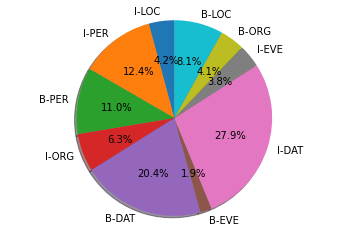

In [ ]:
ne_Count = senInfo.sum(axis = 0)
ne_Count = ne_Count[1:12]
print(pd.DataFrame(ne_Count))
print(ne_Count / sum(ne_Count.values)*100)
ne_Count = ne_Count[1:12]
ne_Count = shuffle(ne_Count)
fig1, ax1 = plt.subplots()
ax1.pie(ne_Count.values, labels=ne_Count.keys(), autopct='%1.1f%%',shadow=True, startangle=90)
ax1.axis('equal') 

In [ ]:
weightClass = senInfo.sum(axis = 0)
weightClass = weightClass[1:12]
weightClass = 1 / weightClass
weightClass.values

array([2.43760345e-07, 3.86012453e-06, 2.82079490e-06, 9.76171650e-06,
       1.86678614e-05, 7.14975155e-06, 6.32091274e-06, 1.92049165e-05,
       1.25211294e-05, 4.07431551e-05, 2.08720336e-05])

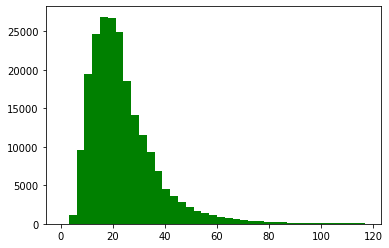

In [ ]:
plt.hist(senLens, bins = np.arange(0,120,3), color = 'green')
plt.show()

## Tokenizationnnnn

In [7]:
yLabel = dataSentences['Label']
sentences = dataSentences['Text']

In [8]:
max_features = 450025   # changeable
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(sentences))
list_tokenized_train = tokenizer.texts_to_sequences(sentences)

y = [[label_to_one_hot(c) for c in ey.split(' ')] for ey in yLabel]

## Padding

In [9]:
maxlen = 60
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
y_t = pad_sequences(y, maxlen=maxlen)
print(len(X_t[0]))
print(len(y_t[0]))

60
60


## Embedding

In [11]:
def loadEmbeddingMatrix(typeToLoad):
    if(typeToLoad=="fasttext"):
        EMBEDDING_FILE='/content/drive/MyDrive/NerDatas/cc.fa.300.vec'
        embed_size = 300

    if(typeToLoad=="glove" or typeToLoad=="fasttext" ):
        embeddings_index = dict()
            #Transfer the embedding weights into a dictionary by iterating through every line of the file.
        with open(EMBEDDING_FILE,'r', encoding='utf8')as f:
            for line in f:
                try:
                    values = line.split()

                    if len(values)==301:
                        word = values[0]    
                        coefs = np.asarray(values[1:], dtype='float32')
                        embeddings_index[word] = coefs
                    elif len(values)==302:
          #print(len(value))
                        word = values[0]+'\u200c'+values[1]   
                        coefs = np.asarray(values[2:], dtype='float32')
                        embeddings_index[word] = coefs
                    elif len(values)==303:
                        word = values[0]+'\u200c'+values[1]+'\u200c'+values[2]  
                        coefs = np.asarray(values[3:], dtype='float32')
                        embeddings_index[word] = coefs
                except Exception as inst:
                        print(inst)
    else:
            embeddings_index = dict()
            for word in word2vecDict.wv.vocab:
                embeddings_index[word] = word2vecDict.word_vec(word)
            #print('Loaded %s word vectors.' % len(embeddings_index))
                        
    gc.collect()
        #We get the mean and standard deviation of the embedding weights so that we could maintain the 
        #same statistics for the rest of our own random generated weights. 
    all_embs = np.stack(list(embeddings_index.values()))
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
        
    nb_words = len(tokenizer.word_index)
        #We are going to set the embedding size to the pretrained dimension as we are replicating it.
        #the size will be Number of Words in Vocab X Embedding Size
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    gc.collect()

        #With the newly created embedding matrix, we'll fill it up with the words that we have in both 
        #our own dictionary and loaded pretrained embedding. 
    embeddedCount = 0
    for word, i in tokenizer.word_index.items():
            i-=1
            #then we see if this word is in glove's dictionary, if yes, get the corresponding weights
            embedding_vector = embeddings_index.get(word)
            #and store inside the embedding matrix that we will train later on.
            if embedding_vector is not None: 
                embedding_matrix[i] = embedding_vector
                embeddedCount+=1
    print('total embedded:',embeddedCount,'common words')
        
    del(embeddings_index)
    gc.collect()
        
        #finally, return the embedding matrix
    return embedding_matrix

In [12]:
embedding_matrix = loadEmbeddingMatrix('fasttext') #we use the lower line instead of runing several times 

total embedded: 118485 common words


In [16]:
np.save('/content/drive/MyDrive/NerDatas/Embedding/embedding_matrix.csv3.npy', embedding_matrix)

In [ ]:
embedding_matrix = np.load('/content/drive/MyDrive/NerDatas/Embedding/embedding_matrix.csv2.npy')

In [ ]:
#embedding_matrix = np.load('/content/drive/MyDrive/NerDatas/Embedding/embedding_matrix.csv.npy')

## 

In [ ]:
! pip install git+https://www.github.com/keras-team/keras-contrib.git 

## Split to train and test

In [ ]:
np.save('/content/drive/MyDrive/NerDatas/innerInputs/X_t.txt', X_t)
np.save('/content/drive/MyDrive/NerDatas/innerInputs/y_t.txt', y_t)

In [ ]:
X_t = np.load('/content/drive/MyDrive/NerDatas/innerInputs/X_t.txt.npy')
y_t = np.load('/content/drive/MyDrive/NerDatas/innerInputs/y_t.txt.npy')

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_t, y_t, test_size=0.08, random_state=23)

In [ ]:
pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 6.0 MB/s 


In [18]:
import numpy as np
import tensorflow
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from tensorflow.keras.utils import plot_model
#from tensorflow.keras.layers import CRF
import tensorflow as tf

output_dim = 100
n_tags = 11
model = Sequential()

#model.add(Embedding(input_dim=len(token2idx) + 1, output_dim=output_dim, input_length=int(mean_sentence_length) + 20))
model.add(Embedding(len(tokenizer.word_index), embedding_matrix.shape[1],
                    weights=[embedding_matrix], trainable=False ))
# Add bidirectional LSTM
model.add(Bidirectional(LSTM(units=output_dim, return_sequences=True, dropout=0.1, recurrent_dropout=0.1), merge_mode = 'concat'))

# Add LSTM
model.add(LSTM(units=output_dim, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))

# Add timeDistributed Layer
#model.add(TimeDistributed(Dense(n_tags, activation="relu")))
model.add(Dense(11, activation='softmax'))
#model.add(tfa.layers.CRF(11))

#Optimiser 
#adam = k.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999)

# Compile model
model.compile(loss='categorical_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.01,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name='Adam'
),
                  metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 300)         40960500  
                                                                 
 bidirectional (Bidirectiona  (None, None, 200)        320800    
 l)                                                              
                                                                 
 lstm_1 (LSTM)               (None, None, 100)         120400    
                                                                 
 dense (Dense)               (None, None, 11)          1111      
                                                                 
Total params: 41,402,811
Trainable params: 442,311
Non-trainable params: 40,960,500
_________________________________________________________________


In [19]:
from keras.callbacks import ModelCheckpoint

batch_size = 256
epochs = 5

filepath="/content/drive/MyDrive/NerDatas/check_point/modelCheckpoint_fromNewSource1.model"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max', )
callbacks_list = [checkpoint]
hist = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, callbacks=callbacks_list, validation_split=0.08)

Epoch 1/5
716/716 [==============================] - ETA: 0s - loss: 0.2495 - accuracy: 0.9280 - precision: 0.8450 - recall: 0.7842
Epoch 1: val_accuracy improved from -inf to 0.95118, saving model to /content/drive/MyDrive/NerDatas/check_point/modelCheckpoint_fromNewSource1.model


716/716 [==============================] - 528s 720ms/step - loss: 0.2495 - accuracy: 0.9280 - precision: 0.8450 - recall: 0.7842 - val_loss: 0.1522 - val_accuracy: 0.9512 - val_precision: 0.8946 - val_recall: 0.8507
Epoch 2/5
716/716 [==============================] - ETA: 0s - loss: 0.1431 - accuracy: 0.9531 - precision: 0.8965 - recall: 0.8587
Epoch 2: val_accuracy improved from 0.95118 to 0.95934, saving model to /content/drive/MyDrive/NerDatas/check_point/modelCheckpoint_fromNewSource1.model


716/716 [==============================] - 521s 727ms/step - loss: 0.1431 - accuracy: 0.9531 - precision: 0.8965 - recall: 0.8587 - val_loss: 0.1207 - val_accuracy: 0.9593 - val_precision: 0.9101 - val_recall: 0.8789
Epoch 3/5
716/716 [==============================] - ETA: 0s - loss: 0.1224 - accuracy: 0.9581 - precision: 0.9075 - recall: 0.8764
Epoch 3: val_accuracy improved from 0.95934 to 0.96223, saving model to /content/drive/MyDrive/NerDatas/check_point/modelCheckpoint_fromNewSource1.model


716/716 [==============================] - 521s 727ms/step - loss: 0.1224 - accuracy: 0.9581 - precision: 0.9075 - recall: 0.8764 - val_loss: 0.1098 - val_accuracy: 0.9622 - val_precision: 0.9143 - val_recall: 0.8905
Epoch 4/5
716/716 [==============================] - ETA: 0s - loss: 0.1111 - accuracy: 0.9616 - precision: 0.9137 - recall: 0.8866
Epoch 4: val_accuracy improved from 0.96223 to 0.96466, saving model to /content/drive/MyDrive/NerDatas/check_point/modelCheckpoint_fromNewSource1.model


716/716 [==============================] - 518s 723ms/step - loss: 0.1111 - accuracy: 0.9616 - precision: 0.9137 - recall: 0.8866 - val_loss: 0.1009 - val_accuracy: 0.9647 - val_precision: 0.9203 - val_recall: 0.8966
Epoch 5/5
716/716 [==============================] - ETA: 0s - loss: 0.1035 - accuracy: 0.9638 - precision: 0.9183 - recall: 0.8932
Epoch 5: val_accuracy improved from 0.96466 to 0.96623, saving model to /content/drive/MyDrive/NerDatas/check_point/modelCheckpoint_fromNewSource1.model


716/716 [==============================] - 520s 726ms/step - loss: 0.1035 - accuracy: 0.9638 - precision: 0.9183 - recall: 0.8932 - val_loss: 0.0953 - val_accuracy: 0.9662 - val_precision: 0.9226 - val_recall: 0.9024


In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
from keras.layers import  TimeDistributed, Masking, Conv1D, MaxPooling1D, Flatten
from keras_contrib.layers import CRF
from keras_contrib.losses import crf_loss
from keras_contrib.metrics import crf_viterbi_accuracy, crf_accuracy
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
from keras import backend as K


model = Sequential()
# model.add(Dense(shape=(maxlen,)))
model.add(Embedding(len(tokenizer.word_index), embedding_matrix.shape[1],
                    weights=[embedding_matrix],trainable=False ))
model.add(Bidirectional(LSTM(200, return_sequences=True,
                             name='lstm_layer1', dropout=0.1, recurrent_dropout=0.1)))
model.add(Bidirectional(LSTM(300, return_sequences=True,
                              name='lstm_layer2', dropout=0.1, recurrent_dropout=0.1)))
model.add(Bidirectional(LSTM(300, return_sequences=True,
                              name='lstm_layer3', dropout=0.1, recurrent_dropout=0.1)))
model.add(Bidirectional(LSTM(200, return_sequences=True,
                              name='lstm_layer4', dropout=0.1, recurrent_dropout=0.1)))
model.add(Dense(11, activation='softmax'))

model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy',tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
model.summary()

In [ ]:
from keras.layers import  TimeDistributed, Masking, Conv1D, MaxPooling1D, Flatten
from keras_contrib.layers import CRF
from keras_contrib.losses import crf_loss
from keras_contrib.metrics import crf_viterbi_accuracy, crf_accuracy
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
from keras import backend as K


# weightClass = senInfo.sum(axis = 0)
# weightClass = weightClass[1:12]
# weightClass = 1 / weightClass
# weightClass = dict(zip(range(12), weightClass.values))

model = Sequential()
# model.add(Dense(shape=(maxlen,)))
model.add(Embedding(len(tokenizer.word_index), embedding_matrix.shape[1],
                    weights=[embedding_matrix],trainable=False ))
model.add(Bidirectional(LSTM(200, return_sequences=True,
                             name='lstm_layer1', dropout=0.1, recurrent_dropout=0.1)))
model.add(Bidirectional(LSTM(350, return_sequences=True,
                              name='lstm_layer2', dropout=0.1, recurrent_dropout=0.1)))
model.add(Bidirectional(LSTM(250, return_sequences=True,
                              name='lstm_layer3', dropout=0.1, recurrent_dropout=0.1)))
# model.add(Dense(11, activation='softmax'))
model.add(CRF(11, sparse_target=True) )  # CRF layer

# # model.add(CRF(11, sparse_target=True))

# # model.compile(loss = crf_loss ,
# #                   optimizer = 'adam',
# #                   metrics=['accuracy',tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]) #loss = weightedLoss(crf_loss, weightClass)
model.summary()

In [ ]:
from keras.layers import  TimeDistributed, Masking, Conv1D, MaxPooling1D, Flatten
from keras_contrib.layers import CRF
from keras_contrib.losses import crf_loss
from keras_contrib.metrics import crf_viterbi_accuracy, crf_accuracy
from keras.models import Sequential

model = Sequential()
model.add(Embedding(len(tokenizer.word_index), embedding_matrix.shape[1],weights=[embedding_matrix],trainable=False))
model.add(Bidirectional(LSTM(30, return_sequences=True,name='lstm')))
model.add(Bidirectional(LSTM(30, return_sequences=True,name='lstm')))
model.add(Conv1D(60, 1, activation='relu'))
model.add(MaxPooling1D(1))
model.add(Conv1D(60, 1, activation='relu'))
model.add(MaxPooling1D(1))# global max pooling
model.add(CRF(11, sparse_target=True))  # CRF layer,

model.compile(optimizer="rmsprop", loss=crf_loss, metrics=[crf_accuracy])

model.summary()

## pretrained Models

In [ ]:
from transformers import AutoTokenizer
from transformers import AutoModelForTokenClassification  # for pytorch
from transformers import TFAutoModelForTokenClassification  # for tensorflow
from transformers import pipeline


model_name_or_path = "HooshvareLab/distilbert-fa-zwnj-base-ner" 
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)
model = TFAutoModelForTokenClassification.from_pretrained(model_name_or_path, num_labels=11, ignore_mismatched_sizes=True)
model.summary()

All model checkpoint layers were used when initializing TFDistilBertForTokenClassification.

Some weights of TFDistilBertForTokenClassification were not initialized from the model checkpoint at HooshvareLab/distilbert-fa-zwnj-base-ner and are newly initialized because the shapes did not match:
- classifier/kernel:0: found shape (768, 21) in the checkpoint and (768, 11) in the model instantiated
- classifier/bias:0: found shape (21,) in the checkpoint and (11,) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_distil_bert_for_token_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 75177984  
 nLayer)                                                         
                                                                 
 dropout_19 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  8459      
                                                                 
Total params: 75,186,443
Trainable params: 75,186,443
Non-trainable params: 0
_________________________________________________________________


In [ ]:
type(model.distilbert)

transformers.models.distilbert.modeling_tf_distilbert.TFDistilBertMainLayer

In [ ]:
model.distilbert.trainable = False
model.summary()

In [ ]:
model.num_labels = 11
model.config.num_labels = 11


In [ ]:
from transformers import AutoTokenizer, DataCollatorForTokenClassification, AutoModelForTokenClassification, TrainingArguments, Trainer
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=40,
    weight_decay=0.01,
)

train_ds = dm.as_hf_dataset(tokenizer=tokenizer)

NameError: ignored

In [ ]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                  optimizer = 'adam',
                  metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [ ]:
from keras.callbacks import ModelCheckpoint

batch_size = 512
epochs = 5

filepath="/content/drive/MyDrive/NerDatas/check_point/pretrainedDistilBert.model"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max', )
callbacks_list = [checkpoint]
hist = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, callbacks=callbacks_list, validation_split=0.1)

Epoch 1/5


InvalidArgumentError: ignored

In [ ]:
pred = model.predict(X_train[:16])['logits']

In [ ]:
import numpy as np
import tensorflow
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from tensorflow.keras.utils import plot_model
from keras.models import load_model
model1 = Sequential()
model1 = load_model("/content/drive/MyDrive/NerDatas/check_point/check_point4.model")

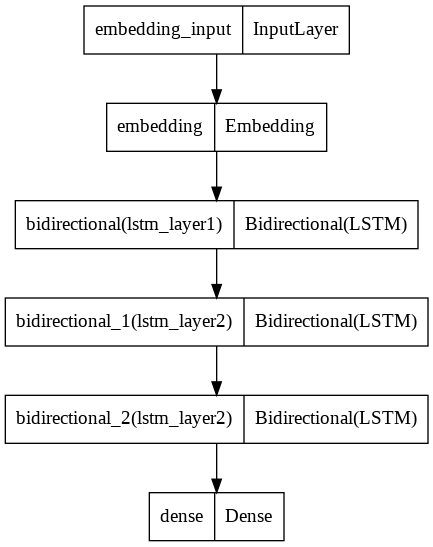

In [ ]:
plot_model(model1)

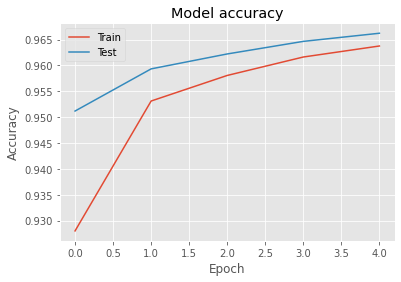

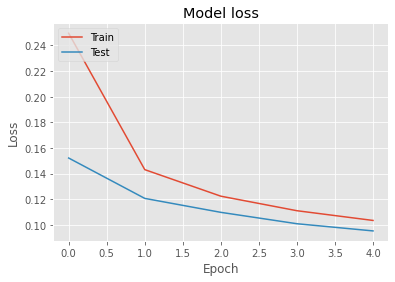

In [20]:
# Visualize the Model
plt.style.use("ggplot")
import matplotlib.pyplot as plt
# Plot training & validation accuracy values
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [21]:
y_pred = model.predict(X_test)

In [22]:
y_pred.shape, y_train.shape

((17322, 60, 11), (199198, 60, 11))

In [23]:
len(y_pred.flatten()), len(y_test.flatten().astype('float32')), y_test.flatten().astype('float32')

(11432520, 11432520, array([0., 0., 0., ..., 0., 0., 0.], dtype=float32))

In [24]:
np.argmax(y_pred[116], axis = 1) ,np.argmax(y_test[116], axis = 1)

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 3, 0, 0, 0, 0, 0, 1, 2, 2, 0, 0, 0, 0, 0]))

In [26]:
y_predC = []
y_testC = []
for pred,test in zip(y_pred, y_test):
  y_predC.append(np.argmax(pred, axis = 1))
  y_testC.append(np.argmax(test, axis = 1))
y_predC = np.array(y_predC)
y_testC = np.array(y_testC)

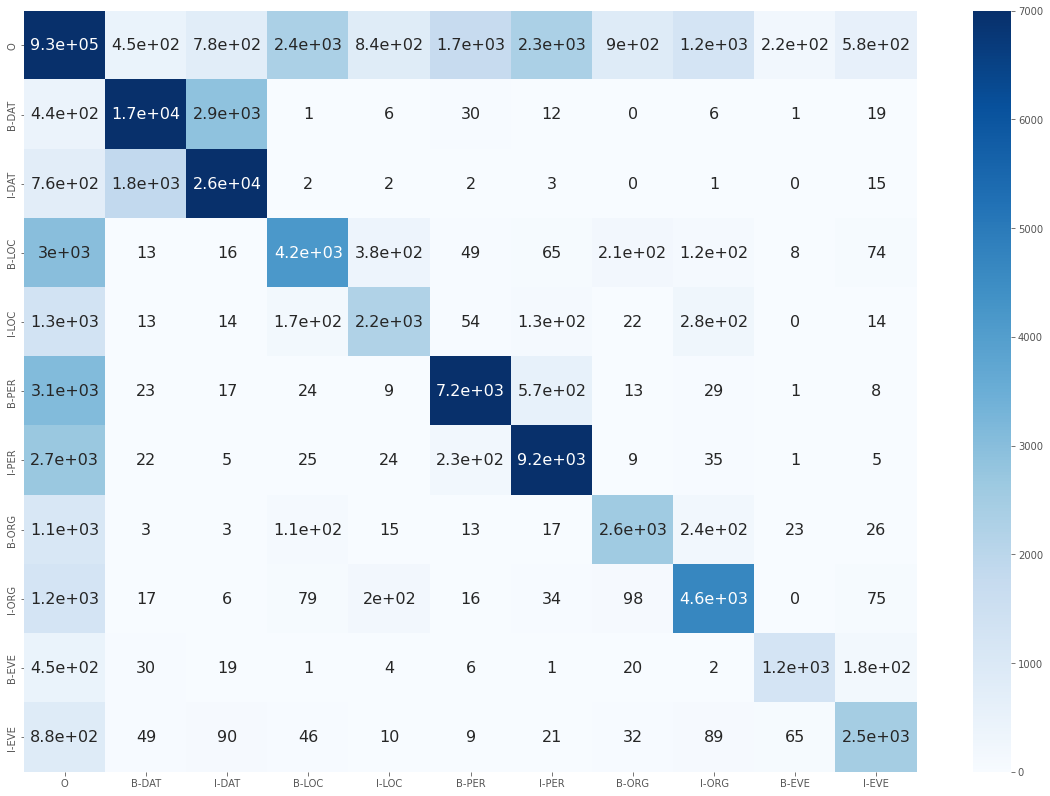

In [32]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sn
target_names = ['O', 'B-DAT', 'I-DAT', 'B-LOC', 'I-LOC', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-EVE', 'I-EVE']
cfnMatrix = confusion_matrix(y_testC.flatten(), y_predC.flatten())
df_cm = pd.DataFrame(cfnMatrix, index = target_names,columns = target_names)
plt.figure(figsize = (20,14))
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap="Blues", vmin=0, vmax=7000) #, vmin=0, vmax=2000

In [29]:
np.sort(cfnMatrix) / np.sum(cfnMatrix, axis=1)

array([[2.35496706e-04, 2.17884922e-02, 2.06396890e-02, 9.64760966e-02,
        1.96713615e-01, 8.14228530e-02, 1.01957586e-01, 4.21039903e-01,
        3.64261168e-01, 1.20698511e+00, 2.45757423e+02],
       [0.00000000e+00, 4.83115126e-05, 3.53419332e-05, 7.39280434e-04,
        1.40845070e-03, 1.09170306e-03, 1.54975530e-03, 7.25513906e-03,
        6.79475164e-02, 1.47508988e+00, 4.59093319e+00],
       [0.00000000e+00, 0.00000000e+00, 3.53419332e-05, 2.46426811e-04,
        4.69483568e-04, 1.81950509e-04, 2.44698206e-04, 3.62756953e-03,
        1.19493908e-01, 9.45557268e-01, 6.80381760e+00],
       [8.52476765e-06, 6.28049664e-04, 5.65470931e-04, 6.03745688e-03,
        1.52582160e-02, 6.73216885e-03, 9.62479608e-03, 5.03022975e-02,
        5.93564511e-02, 1.54288649e+00, 1.10843054e+00],
       [0.00000000e+00, 6.28049664e-04, 4.94787065e-04, 1.72498768e-03,
        5.16431925e-03, 4.91266376e-03, 1.07667210e-02, 4.08706167e-02,
        4.40487348e-02, 6.77452491e-01, 5.94114528e-

In [28]:
from sklearn.metrics import classification_report
target_names = ['O', 'B-DAT', 'I-DAT', 'B-LOC', 'I-LOC', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-EVE', 'I-EVE']
print(classification_report(y_testC.flatten(), y_predC.flatten(), target_names=target_names))

              precision    recall  f1-score   support

           O       0.98      0.99      0.99    938442
       B-DAT       0.88      0.84      0.86     20699
       I-DAT       0.87      0.91      0.89     28295
       B-LOC       0.60      0.52      0.55      8116
       I-LOC       0.60      0.53      0.56      4260
       B-PER       0.77      0.66      0.71     10992
       I-PER       0.74      0.75      0.75     12260
       B-ORG       0.67      0.62      0.64      4135
       I-ORG       0.69      0.73      0.71      6402
       B-EVE       0.79      0.63      0.71      1947
       I-EVE       0.71      0.66      0.68      3772

    accuracy                           0.97   1039320
   macro avg       0.76      0.71      0.73   1039320
weighted avg       0.96      0.97      0.97   1039320



## history


In [ ]:
def weightedLoss(originalLossFunc, weightsList):

    def lossFunc(true, pred):

        axis = -1 #if channels last 
        #axis=  1 #if channels first


        #argmax returns the index of the element with the greatest value
        #done in the class axis, it returns the class index    
        classSelectors = K.argmax(true, axis=axis) 
            #if your loss is sparse, use only true as classSelectors
        print(type(classSelectors[0]))
        #considering weights are ordered by class, for each class
        #true(1) if the class index is equal to the weight index   
        classSelectors = classSelectors.astype(np.int32)
        classSelectors = [K.equal(i, classSelectors) for i in range(len(weightsList))]

        #casting boolean to float for calculations  
        #each tensor in the list contains 1 where ground true class is equal to its index 
        #if you sum all these, you will get a tensor full of ones. 
        classSelectors = [K.cast(x, K.floatx()) for x in classSelectors]

        #for each of the selections above, multiply their respective weight
        weights = [sel * w for sel,w in zip(classSelectors, weightsList)] 

        #sums all the selections
        #result is a tensor with the respective weight for each element in predictions
        weightMultiplier = weights[0]
        for i in range(1, len(weights)):
            weightMultiplier = weightMultiplier + weights[i]


        #make sure your originalLossFunc only collapses the class axis
        #you need the other axes intact to multiply the weights tensor
        loss = originalLossFunc(true,pred) 
        loss = loss * weightMultiplier

        return loss
    return lossFunc